# Model Tuning

This notebook discusses techniques to improve the performance of a model: particularly in the case where we do not have a lot of training data and the models can be prone to overfitting. It covers several strategies:

* Network modifications
    * Drop-out Layers
    * Batch Normalization Layers
* Data Augmentation
* Tranfer Learning

Along the way we will also go through details on
* Monitoring Performance
* Visualizing Results
* Loading and Saving Models

This notebook is built on these sources:

* [*Tensorflow Classification Tutorial*](https://www.tensorflow.org/tutorials/images/classification)

* [*Transfer Learning with VGG16 and Keras*](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4),  Medium Blog Post by Gabriel Cassimiro

## Setup

Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Flowers Dataset

This tutorial uses a [dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) of about 3,700 photos of flowers. The dataset contains five types of flowers:

```
  daisy
  dandelion
  roses
  sunflowers
  tulips
```

The dataset is part of a collection of [datasets](https://www.tensorflow.org/datasets) in the `tensorflow` library which can be directly loaded.

In [2]:
# downloading images

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')


image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

228813984/228813984 [==============================] - 2s 0us/step
3670


In [3]:
# the images are arranged in folders with their names
import os
list(os.walk(data_dir))[0]

('/root/.keras/datasets/flower_photos',
 ['roses', 'sunflowers', 'daisy', 'tulips', 'dandelion'],
 ['LICENSE.txt'])

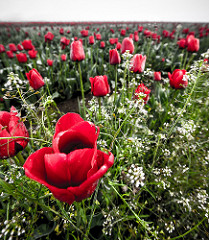

In [4]:
# looking at a few tulips
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

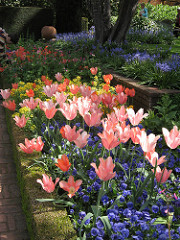

In [5]:
PIL.Image.open(str(tulips[1]))

#### Images are not the same size!

The images in the dataset are not the same size so we will resize them so that it is easier to put them in an array and process them efficiently. We fix the weight and height to be 150. This resizing can be achieved automatically while reading the data with the `tf.keras.utils.image_dataset_from_directory` function and setting the image size.

In [54]:
HEIGHT = 150
WIDTH = 150

In [61]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  labels="inferred",
  label_mode="categorical",
  seed=123,
  image_size=(HEIGHT, WIDTH),
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  labels="inferred",
  label_mode="categorical",
  seed=123,
  image_size=(HEIGHT, WIDTH),
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Hold Out Test Set
Not we set aside 20% for a test set which we will NOT use in model training and selection. It is easy to overtune the model performance to the specific test we have selected and because we have no more "unseen" data to test on our measures of performance may be skewed. We will only use the test set in the end to evaluate the performance on "unseen" data.

In [62]:
# convert to numpy arrays
train_images, train_labels = zip(*list(train_ds.unbatch()))
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [9]:
print(train_images.shape)
print(train_labels.shape)

(2936, 150, 150, 3)
(2936, 5)


We loaded the labels in a categorical format, but we also need the class names. These correspond to the directory names in alphabetical order.

In [10]:
class_names = ["daisy", "dandelion", "roses", "sunflowers","tulips"]
num_classes = len(class_names)

### Visualize the data



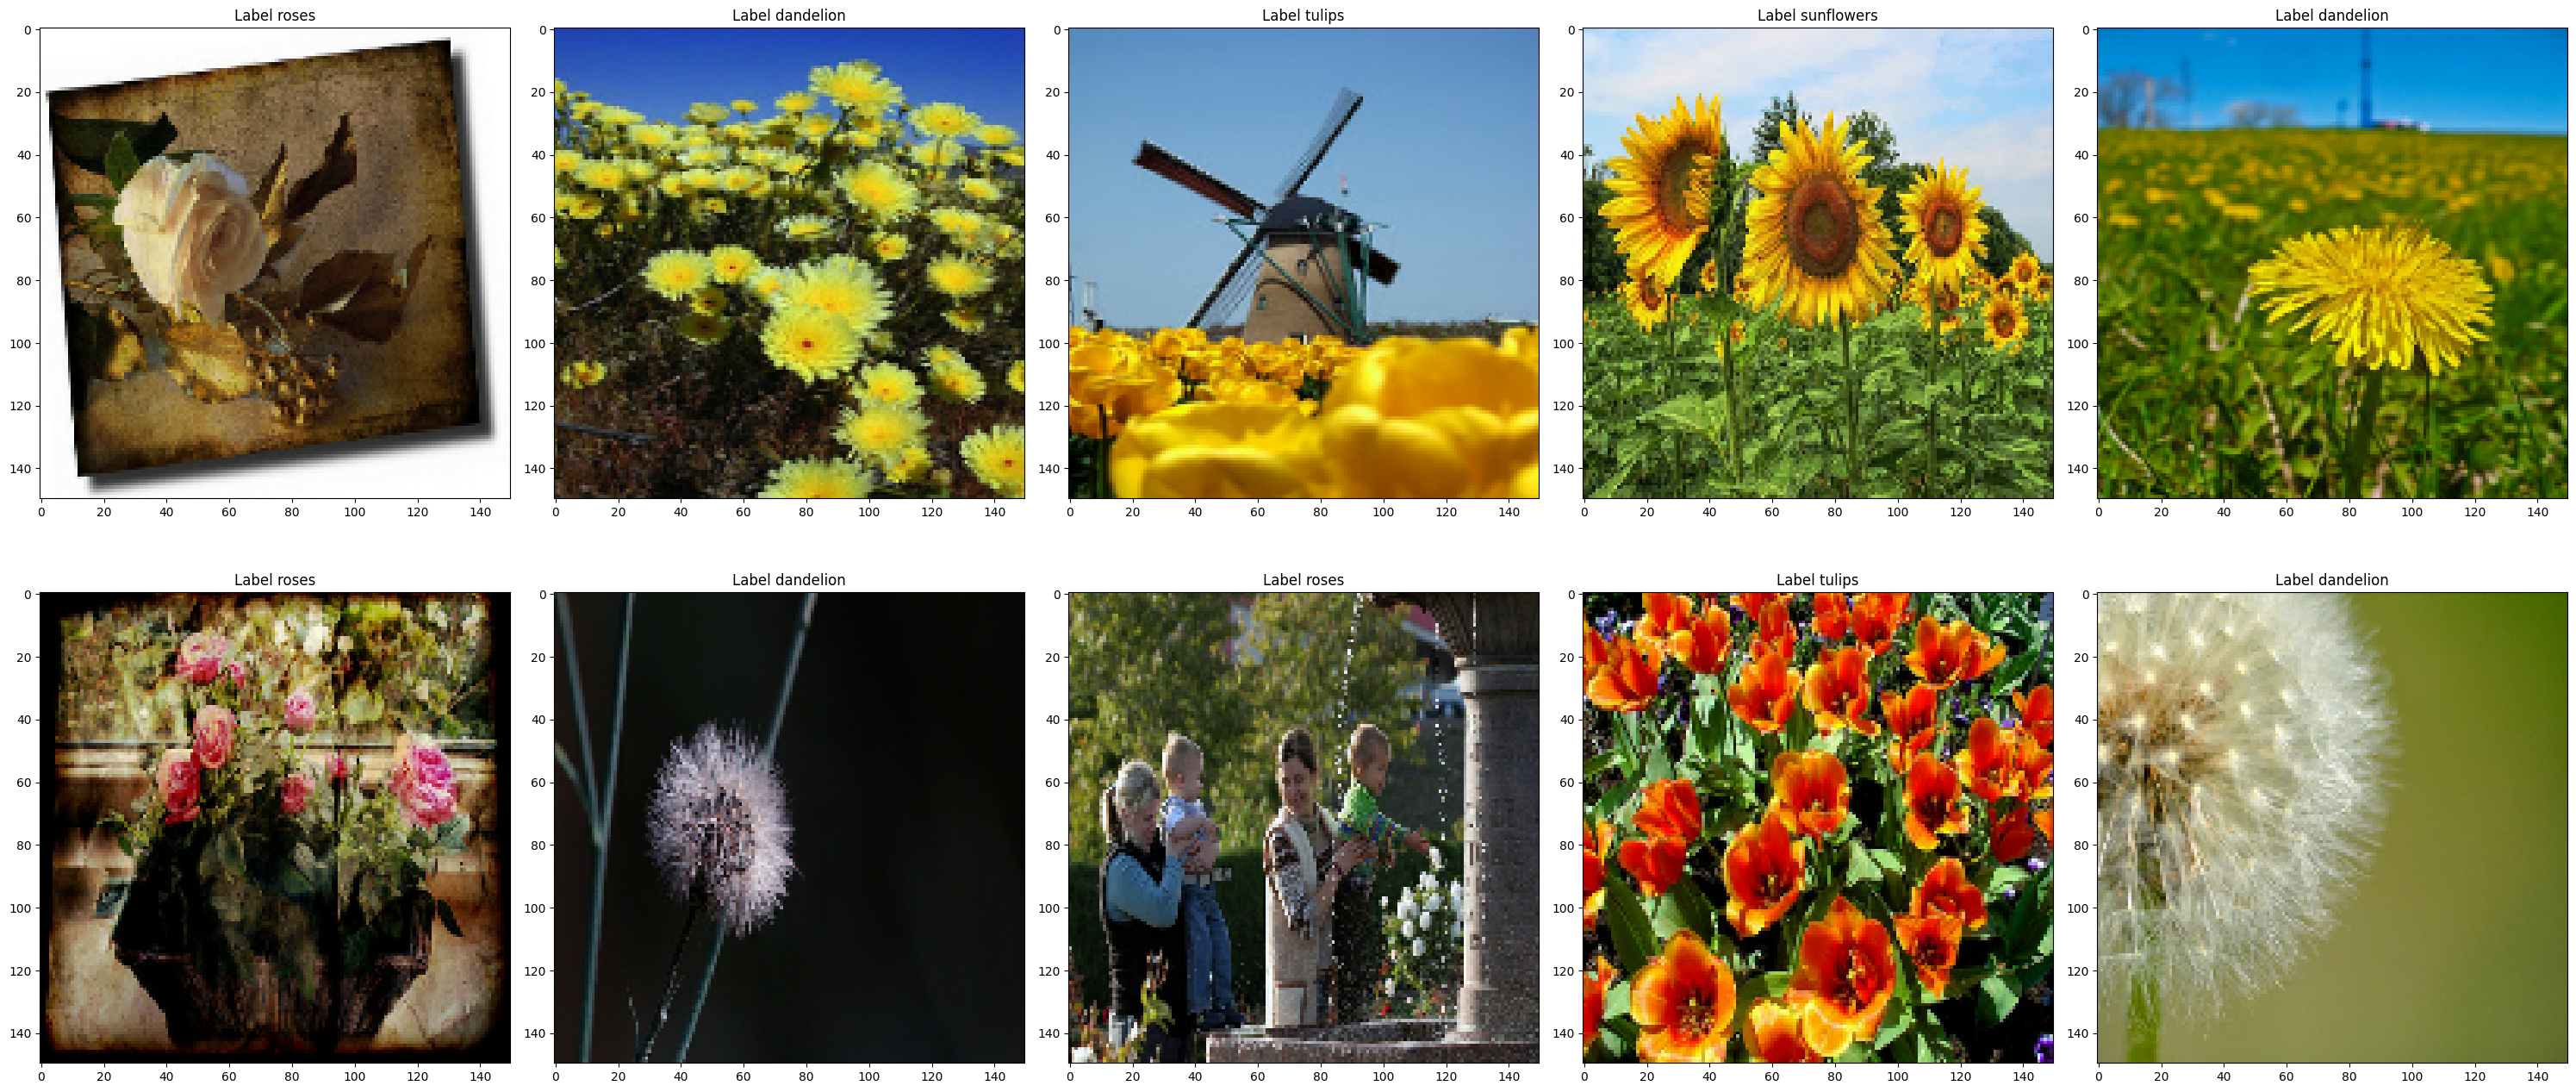

In [11]:
plt.rcParams["figure.figsize"] = [30, 15]
plt.rcParams["figure.autolayout"] = True

counter = 0
for image, label in zip(train_images, train_labels):
  plt.subplot(2, 5, counter+1)
  plt.imshow(image.astype("uint8"))
  label_name = class_names[np.where(label==1)[0][0]]
  plt.title('Label {}'.format(label_name))
  counter += 1
  if counter == 10:
    break

### Rescale the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

We can rescale values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling` in the model definition itself.

In [12]:
layers.Rescaling(1./255)

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [13]:

model = Sequential([
  layers.Rescaling(1./255, input_shape=(HEIGHT, WIDTH, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes, name="outputs", activation='softmax')
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `categorical_crossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

One can pass other built-in metrics or pass their own metric function.

**Exercise** pass other [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) and run the plot below. Modify the plots to visualize the other metrics.

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

### Train the model

We set the max number of epochs to 50 in the `Model.fit` method, but we will also set an early stopping criterion which will monitor how the algorithm performs on the validation set, and if there is no significant improvement, the algorithm will stop.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [17]:
%%time
epochs=50
history = model.fit(
  train_images,
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 [==============================] - 8s 30ms/step - loss: 1.3630 - accuracy: 0.4276 - val_loss: 1.1558 - val_accuracy: 0.5289
Epoch 2/50
74/74 [==============================] - 1s 18ms/step - loss: 1.0098 - accuracy: 0.6073 - val_loss: 1.1133 - val_accuracy: 0.5527
Epoch 3/50
74/74 [==============================] - 1s 17ms/step - loss: 0.8190 - accuracy: 0.6750 - val_loss: 1.1790 - val_accuracy: 0.5272
Epoch 4/50
74/74 [==============================] - 1s 18ms/step - loss: 0.6629 - accuracy: 0.7577 - val_loss: 1.1132 - val_accuracy: 0.5969
Epoch 5/50
74/74 [==============================] - 1s 18ms/step - loss: 0.4689 - accuracy: 0.8394 - val_loss: 1.2525 - val_accuracy: 0.6071
Epoch 6/50
74/74 [==============================] - 1s 17ms/step - loss: 0.3156 - accuracy: 0.8922 - val_loss: 1.3603 - val_accuracy: 0.6190
Epoch 7/50
74/74 [==============================] - 2s 23ms/step - loss: 0.1907 - accuracy: 0.9344 - val_loss: 1.5714 - val_accuracy: 0.6429
Epoch 8/50
74

Warning! If you run the fit command twice the model will continue to update the existing model, unless you rerun the model definition command.

We observe that

* the training set accuracy is almost 1
* the validation set accuracy is around ~0.6.

### Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

In [18]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

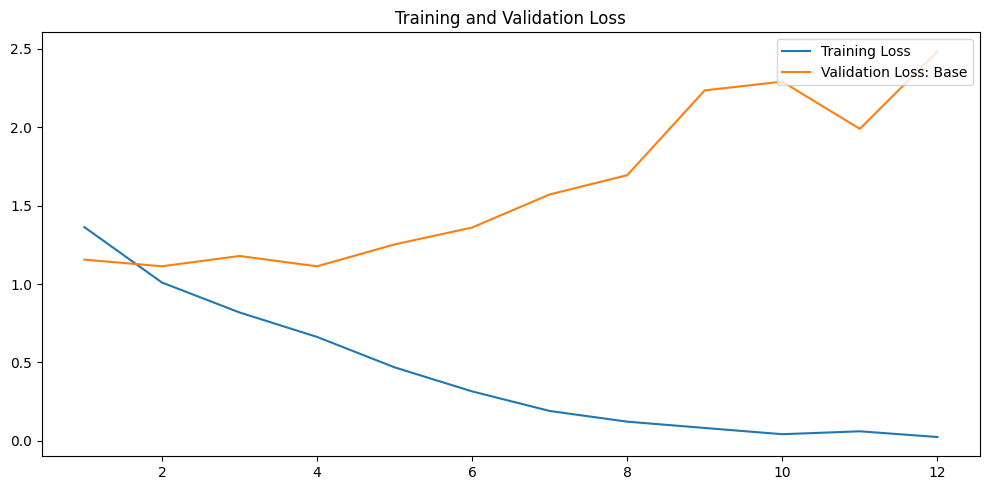

Text(0.5, 1.0, 'Training and Validation Accuracy')

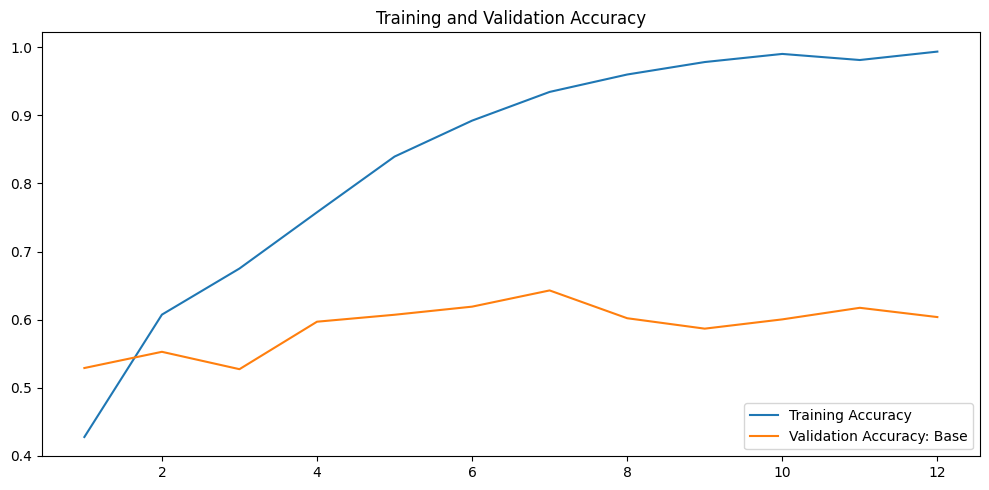

In [19]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss: Base')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy: Base')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.


### Overfitting!

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process and we will discuss those below.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

![image](https://raw.githubusercontent.com/mohcinemadkour/mohcinemadkour.github.io/master/images/dropout/1.gif)

Image from [mohcinemadkour.github.io](https://mohcinemadkour.github.io/posts/2020/04/Deep%20Learning%20Regularization/)



Create a new neural network with `tf.keras.layers.Dropout`.

In [26]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),

  layers.Dense(num_classes, name="outputs", activation='softmax')
])

In [27]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
%%time
epochs=50
history = model.fit(
  train_images,
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 [==============================] - 5s 30ms/step - loss: 1.5065 - accuracy: 0.3509 - val_loss: 1.3335 - val_accuracy: 0.4507
Epoch 2/50
74/74 [==============================] - 2s 22ms/step - loss: 1.2075 - accuracy: 0.4668 - val_loss: 1.2922 - val_accuracy: 0.4830
Epoch 3/50
74/74 [==============================] - 2s 22ms/step - loss: 1.1379 - accuracy: 0.5132 - val_loss: 1.1912 - val_accuracy: 0.5068
Epoch 4/50
74/74 [==============================] - 2s 23ms/step - loss: 1.0640 - accuracy: 0.5622 - val_loss: 1.2623 - val_accuracy: 0.4303
Epoch 5/50
74/74 [==============================] - 2s 24ms/step - loss: 1.0530 - accuracy: 0.5703 - val_loss: 1.1343 - val_accuracy: 0.5238
Epoch 6/50
74/74 [==============================] - 2s 22ms/step - loss: 1.0487 - accuracy: 0.5575 - val_loss: 1.1645 - val_accuracy: 0.5085
Epoch 7/50
74/74 [==============================] - 2s 22ms/step - loss: 0.9648 - accuracy: 0.6086 - val_loss: 1.0925 - val_accuracy: 0.5408
Epoch 8/50
74

* The trainining accuracy is lower!

* The validation accuracy ~ 67%.

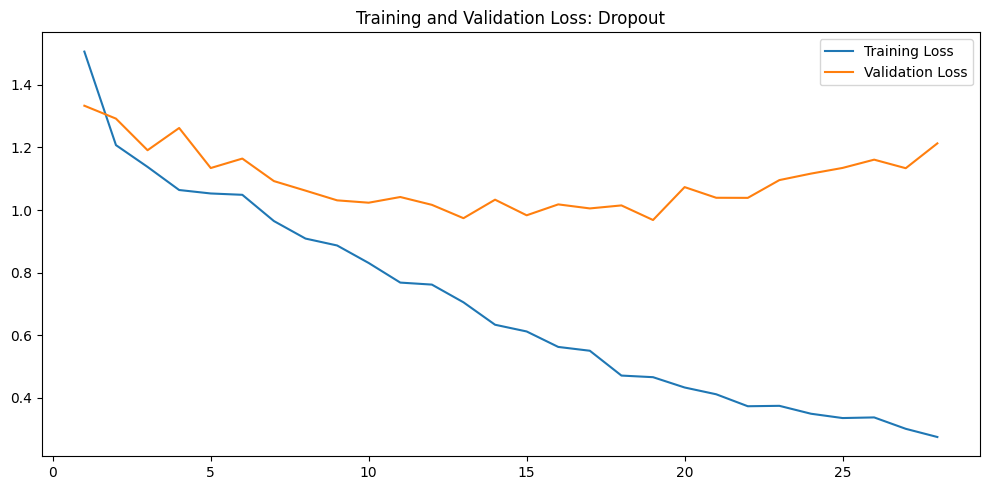

Text(0.5, 1.0, 'Training and Validation Accuracy: Dropout')

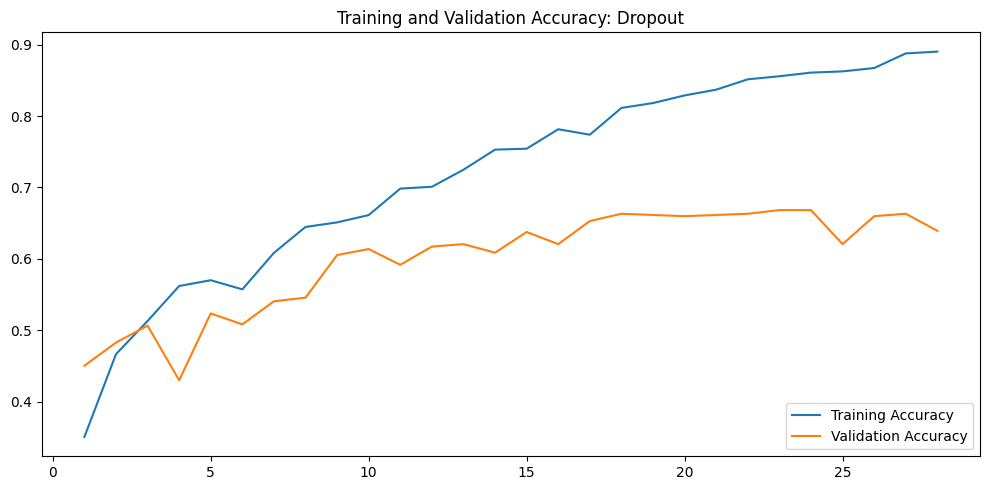

In [29]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Dropout')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Dropout')

## Batch Normalization

![BN_training](https://drive.google.com/uc?export=view&id=1994FYP4lE9XCQnFyHJjhEVmsFGvyc0XT)

![BN_inference](https://drive.google.com/uc?export=view&id=1XJTyOGJv2i-ySr_ivlV8YM3xx8YqxHkR)

In [ ]:
model = Sequential([

  layers.Rescaling(1./255),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #
  #layers.BatchNormalization(),
  #layers.Dropout(0.4),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.4),
  #layers.BatchNormalization(),
  #layers.Dropout(0.4),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.4),
  layers.BatchNormalization(),
  #layers.Dropout(0.4),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  #layers.Dropout(0.4),
  layers.BatchNormalization(),
  #layers.Dropout(0.4),

  layers.Dense(num_classes, name="outputs", activation='softmax')
])


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
%%time
epochs=50
history = model.fit(
  train_images,
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

In [ ]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Batch Normalization')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Batch Normalization')

# Batch Normalization the right way

In [ ]:
model = Sequential([

  layers.Rescaling(1./255),

  layers.Conv2D(16, 3, padding='same'),
  layers.MaxPooling2D(),

  # layers.Dropout(0.4),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.Dropout(0.4),



  layers.Conv2D(32, 3, padding='same'),
  layers.MaxPooling2D(),
  #layers.Activation('relu'),
  #layers.Dropout(0.4),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.Dropout(0.4),



  layers.Conv2D(64, 3, padding='same'),
  layers.MaxPooling2D(),
  #layers.Activation('relu'),
  #layers.Dropout(0.4),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.Dropout(0.4),



  layers.Flatten(),
  layers.Dense(128),
  #layers.Activation('relu'),
  #layers.Dropout(0.4),
  layers.BatchNormalization(),
  layers.Activation('relu'),
  layers.Dropout(0.4),


  layers.Dense(num_classes, name="outputs", activation='softmax')
])


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10,  restore_best_weights=True)

In [ ]:
%%time
epochs=50
history = model.fit(
  train_images,
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

In [ ]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Batch Normalization')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Batch Normalization')

## Data Augmentation

[Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

Visualize a few augmented examples by applying data augmentation to the same image several times:

In [30]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=train_images[0,:,:,:].shape),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

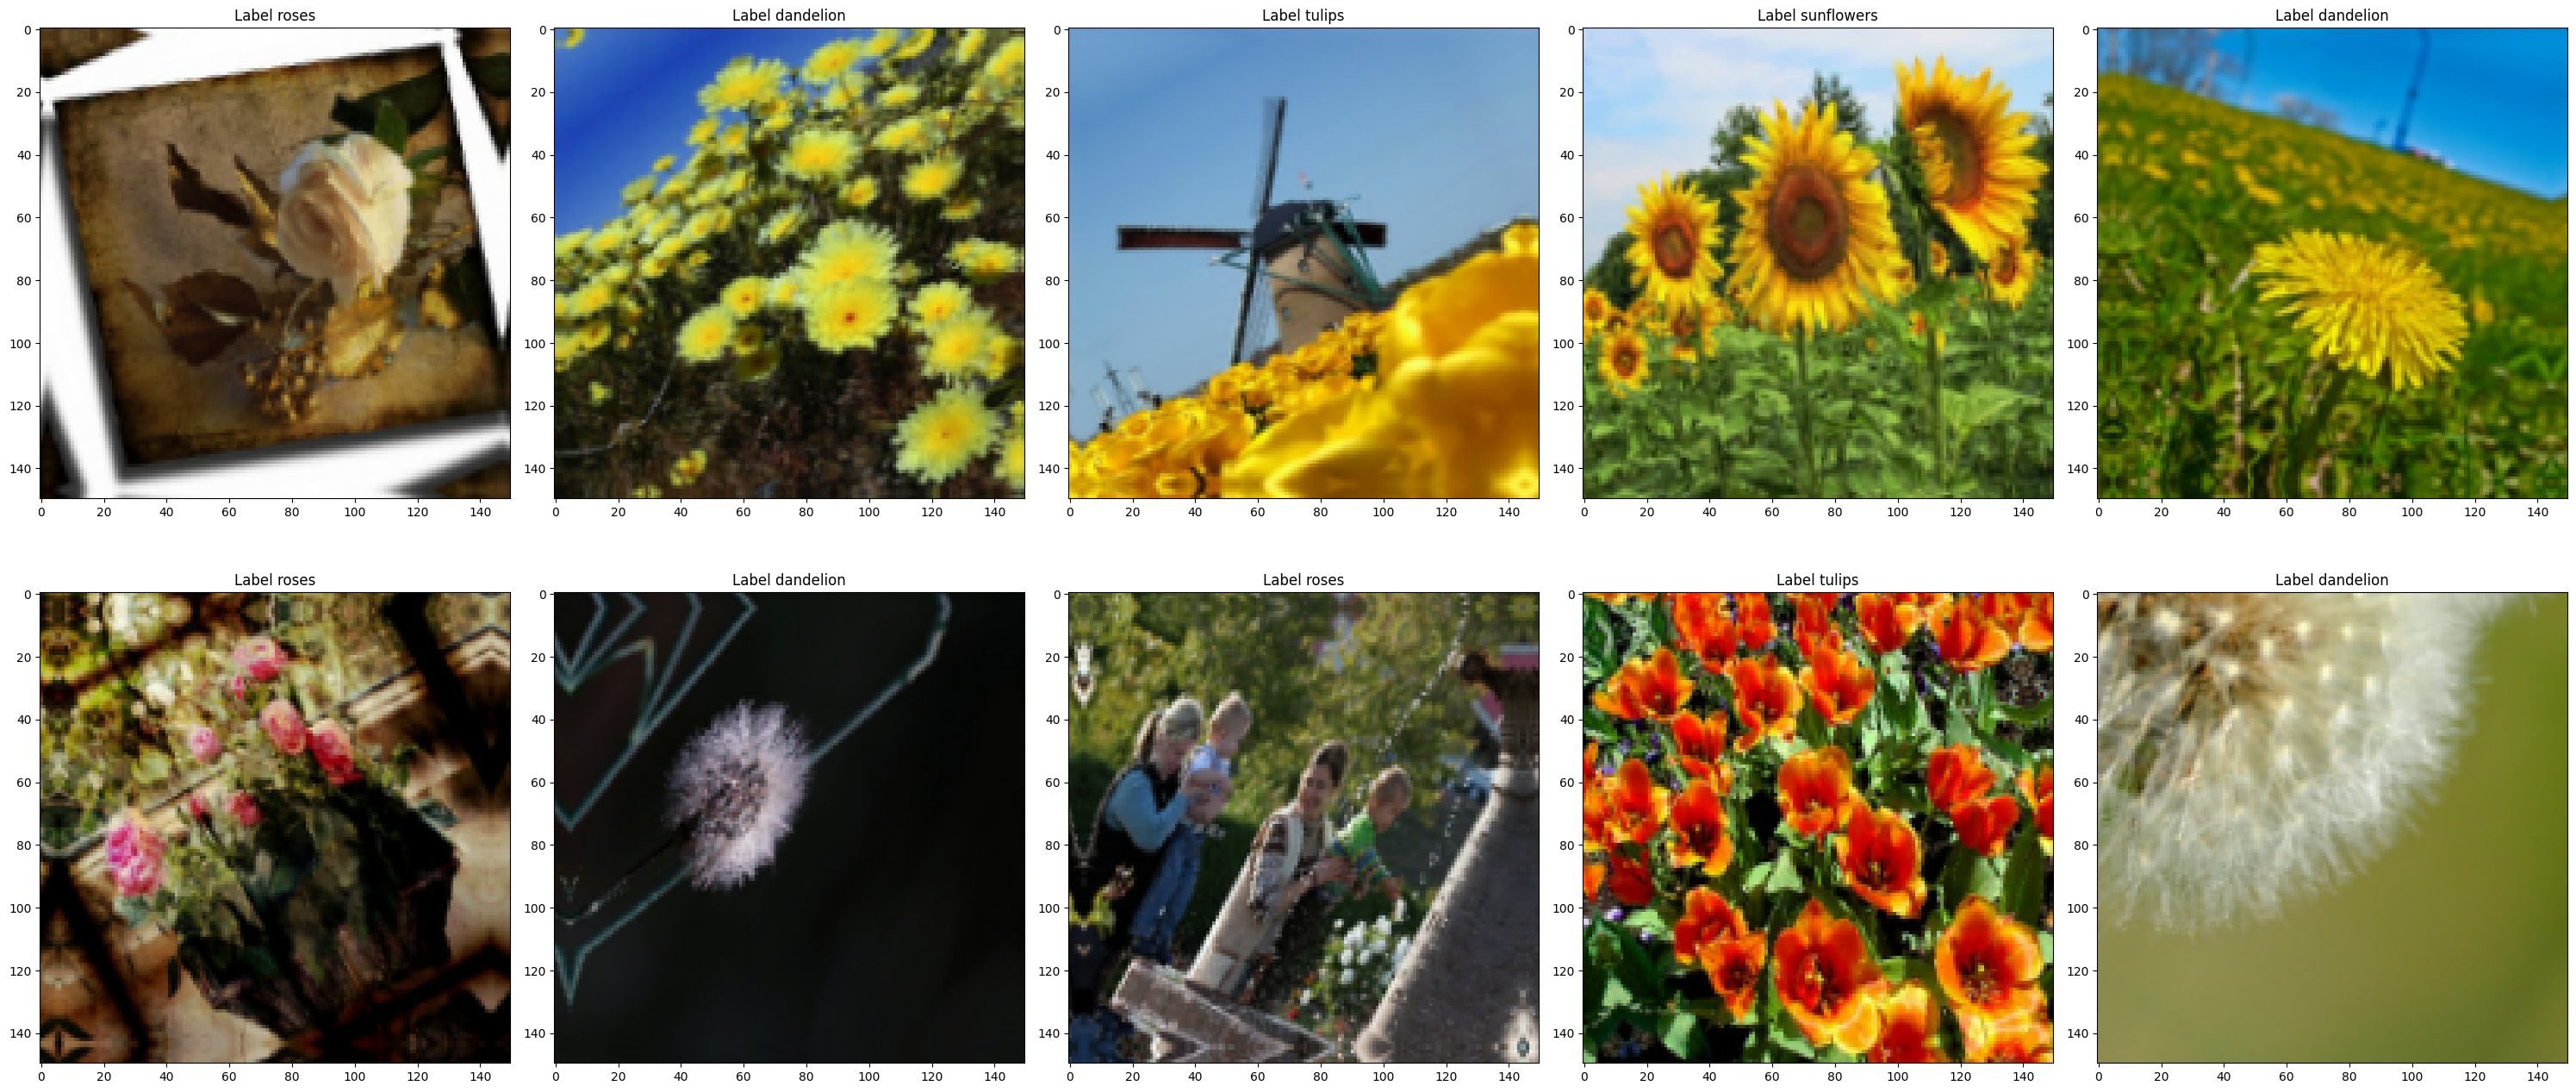

In [42]:
plt.rcParams["figure.figsize"] = [30, 15]
plt.rcParams["figure.autolayout"] = True

counter = 0
for image, label in zip(train_images, train_labels):
  plt.subplot(2, 5, counter+1)
  plt.imshow(data_augmentation(np.reshape(image, (1, HEIGHT, WIDTH, 3))).numpy().astype('uint8').squeeze())
  label_name = class_names[np.where(label==1)[0][0]]
  plt.title('Label {}'.format(label_name))
  counter += 1
  if counter == 10:
    break

We will add data augmentation to your model before training in the next step.

In [43]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),

  layers.Dense(num_classes, name="outputs", activation='softmax')
])

In [44]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
%%time
epochs=50
history = model.fit(
  train_images,
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 [==============================] - 5s 32ms/step - loss: 1.6810 - accuracy: 0.2244 - val_loss: 1.4902 - val_accuracy: 0.3078
Epoch 2/50
74/74 [==============================] - 2s 27ms/step - loss: 1.3909 - accuracy: 0.3710 - val_loss: 1.3603 - val_accuracy: 0.3912
Epoch 3/50
74/74 [==============================] - 3s 36ms/step - loss: 1.2328 - accuracy: 0.4668 - val_loss: 1.2525 - val_accuracy: 0.4354
Epoch 4/50
74/74 [==============================] - 2s 27ms/step - loss: 1.1721 - accuracy: 0.5026 - val_loss: 1.2285 - val_accuracy: 0.5068
Epoch 5/50
74/74 [==============================] - 2s 23ms/step - loss: 1.1309 - accuracy: 0.5311 - val_loss: 1.2738 - val_accuracy: 0.4371
Epoch 6/50
74/74 [==============================] - 2s 23ms/step - loss: 1.1085 - accuracy: 0.5400 - val_loss: 1.2051 - val_accuracy: 0.4932
Epoch 7/50
74/74 [==============================] - 2s 23ms/step - loss: 1.0476 - accuracy: 0.5750 - val_loss: 1.1299 - val_accuracy: 0.5204
Epoch 8/50
74

We observe that:
* training accuracy is ~.76
* validation accuracy is ~.73

In [46]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

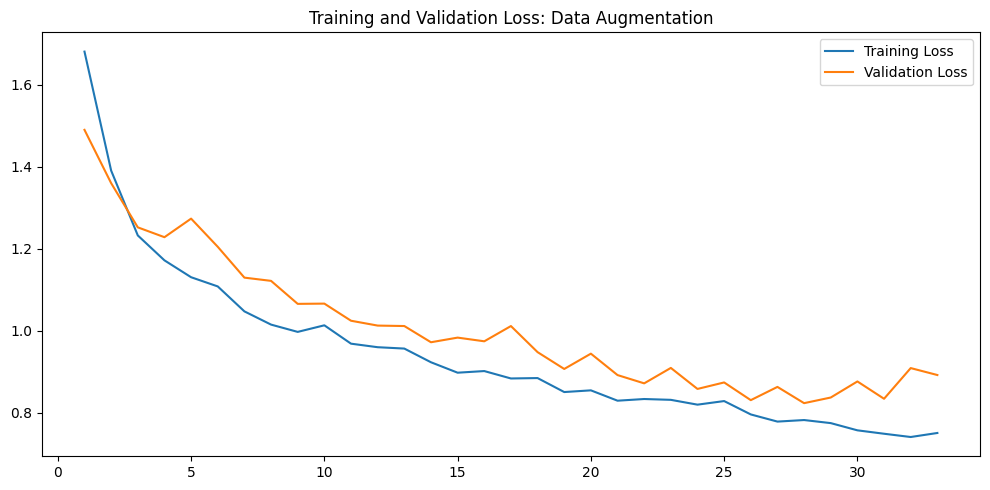

Text(0.5, 1.0, 'Training and Validation Accuracy: Data Augmentation')

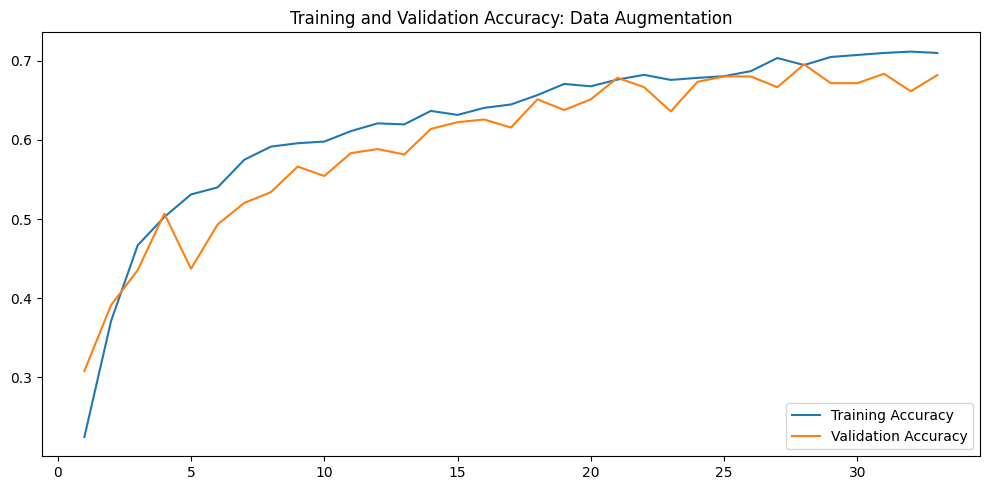

In [47]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Data Augmentation')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Data Augmentation')

The training and validation behavior start to look more similar!

Warning! When doing data augmentation make sure augmented derivatives from the same image do not appear both in your train and validation datasets!

**Exercise** What other data augmentation techniques can be useful for this problem?

## Transfer Learning

Using a **pretrained** model.

![TransferLearning](https://drive.google.com/uc?export=view&id=1QF9-eDrTkMouYJdU4k1qCklT3pLCI61u)

![transfer_learning_chart](https://i.stack.imgur.com/RTKux.png)

### Frozen Pretrained Weights

We will use a rather populat architecture VGG16 trained on the huge Imagenet Dataset.

In [48]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
pretrained_model = VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, 3))
pretrained_model.trainable = False ## Not trainable weights

58889256/58889256 [==============================] - 0s 0us/step


Pretrained models have certain expectations of how the data should look like so that it can be used in the model. They have a corresponding [`preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input) model. Make sure you read on the operations in the preprocessing so that it makes sense for your data.

In [63]:
train_images.max()

255.0

In [64]:
train_images_preprocessed = preprocess_input(train_images.copy()).shape

In [65]:
train_images.max()

255.0

In [77]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(128, activation='relu')
#dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    pretrained_model,
    flatten_layer,
    dense_layer_1,
    #dense_layer_2,
    prediction_layer
])

In [78]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               1048704   
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 15764037 (60.14 MB)
Trainable params: 15764037 (60.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [80]:
%%time
epochs=50
history = model.fit(
  preprocess_input(train_images.copy()),
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 [==============================] - 23s 256ms/step - loss: 78.1362 - accuracy: 0.2807 - val_loss: 1.4134 - val_accuracy: 0.3741
Epoch 2/50
74/74 [==============================] - 18s 237ms/step - loss: 1.2949 - accuracy: 0.4468 - val_loss: 1.2553 - val_accuracy: 0.4847
Epoch 3/50
74/74 [==============================] - 17s 228ms/step - loss: 1.1832 - accuracy: 0.5158 - val_loss: 1.4494 - val_accuracy: 0.3810
Epoch 4/50
74/74 [==============================] - 17s 224ms/step - loss: 1.1196 - accuracy: 0.5426 - val_loss: 1.3579 - val_accuracy: 0.4813
Epoch 5/50
74/74 [==============================] - 17s 224ms/step - loss: 1.0881 - accuracy: 0.5566 - val_loss: 1.1958 - val_accuracy: 0.5136
Epoch 6/50
74/74 [==============================] - 17s 227ms/step - loss: 1.0265 - accuracy: 0.5848 - val_loss: 1.2095 - val_accuracy: 0.5170
Epoch 7/50
74/74 [==============================] - 17s 229ms/step - loss: 1.0332 - accuracy: 0.5703 - val_loss: 1.1765 - val_accuracy: 0.520

* training accuracy is very high again: ~0.98
* validation accuracy is also high: 0.79

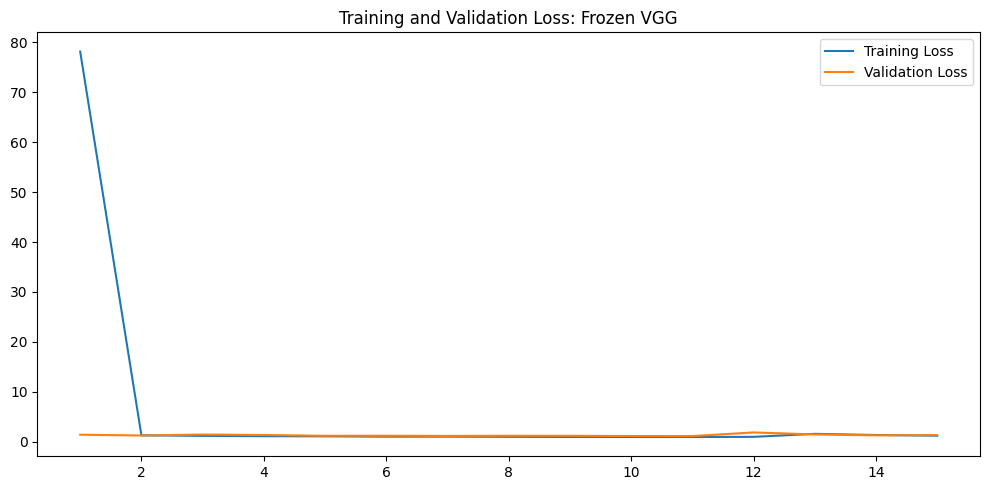

Text(0.5, 1.0, 'Training and Validation Accuracy: Frozen VGG')

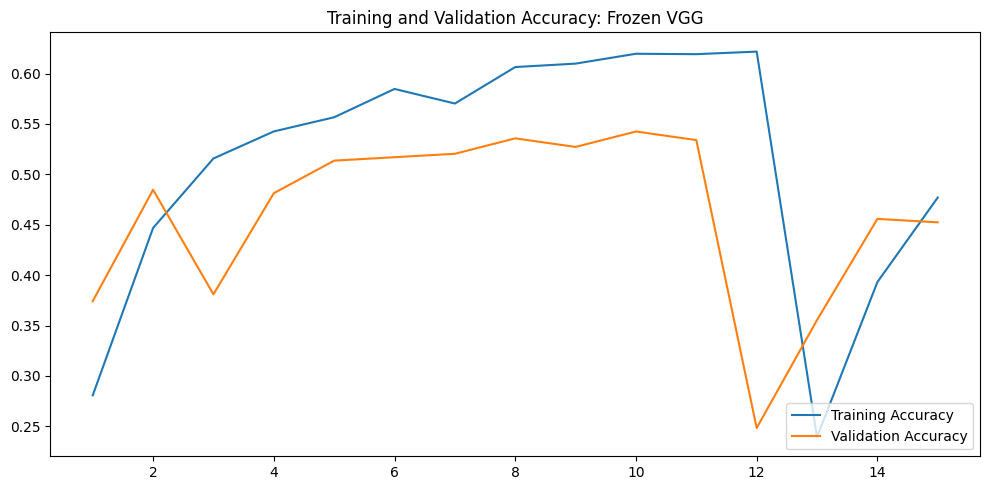

In [81]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Frozen VGG')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Frozen VGG')

### Fine-Tune Pretrained Weights

In [82]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
pretrained_model = VGG16(weights="imagenet", include_top=False, input_shape=train_images[0,:,:,:].shape)
pretrained_model.trainable = True ## Not trainable weights

In [ ]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    pretrained_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [83]:
model.trainable = True

In [84]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [85]:
%%time
epochs=50
history = model.fit(
  preprocess_input(train_images.copy()),
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 [==============================] - 22s 235ms/step - loss: 1.1368 - accuracy: 0.5468 - val_loss: 1.1900 - val_accuracy: 0.5306
Epoch 2/50
74/74 [==============================] - 17s 231ms/step - loss: 0.9740 - accuracy: 0.6188 - val_loss: 1.4041 - val_accuracy: 0.5034
Epoch 3/50
74/74 [==============================] - 17s 228ms/step - loss: 0.9902 - accuracy: 0.6116 - val_loss: 1.1437 - val_accuracy: 0.5408
Epoch 4/50
74/74 [==============================] - 17s 225ms/step - loss: 0.9151 - accuracy: 0.6384 - val_loss: 1.2275 - val_accuracy: 0.5357
Epoch 5/50
74/74 [==============================] - 17s 225ms/step - loss: 0.8985 - accuracy: 0.6422 - val_loss: 1.0997 - val_accuracy: 0.5612
Epoch 6/50
74/74 [==============================] - 17s 226ms/step - loss: 0.8937 - accuracy: 0.6478 - val_loss: 1.1509 - val_accuracy: 0.5629
Epoch 7/50
74/74 [==============================] - 17s 228ms/step - loss: 0.9218 - accuracy: 0.6440 - val_loss: 1.2173 - val_accuracy: 0.5765

In [ ]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Frozen VGG')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Frozen VGG')

## Too Many Experiments!

[TensorBoard](https://www.tensorflow.org/tensorboard) is a tool to visualize experiment performance. It can also visualize results during training. There are many other options but tensorboard is open source and can run locally and integrates with notebooks.

In [ ]:
# add this additional callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

To run tensorboard in a notebook:

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [1]:
# convert to numpy arrays
test_images, test_labels = zip(*list(test_ds.unbatch()))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

NameError: name 'test_ds' is not defined

In [ ]:
predictions = model.predict(test_images)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
plt.imshow(test_images[0,:,:,:]/255.)

## Hyperparameter Tuning

* network parameters
* optimization parameters

[keras tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)